# Load Data

In [1]:
from utils import *

patients = data_preprocessing('AE_Visit_example20k.csv')
X_train, X_test, y_train, y_test = split_data(patients)

In [2]:
from my_model import MyModel

from lstm_model import LSTM
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

params = {'hidden_size': 64, 'lr': 0.001, 'num_epochs': 500, 'region_embedding_dim': 16,
          'time_embedding_dim': 32, 'batch_size': 20000}

xgb_params = {
    'n_estimators': 500,
    'learning_rate': 0.01,
    'tree_method': "hist",
    'objective': 'multi:softmax',  # 使用softmax多分类目标函数
    'num_class': 3,  # 设置类别数为3
}

lgb_params = {
    'objective': 'multiclass',
    'num_class': 3,
    'learning_rate': 0.01,
}

# LSTM + XGBM

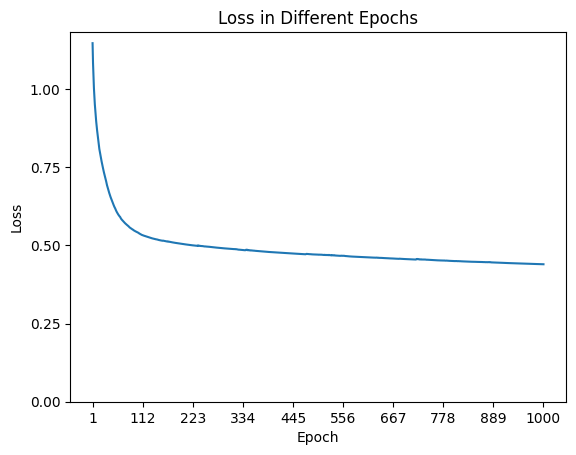

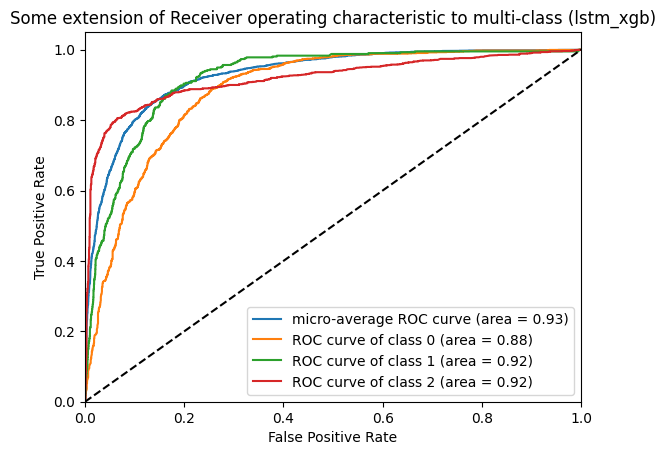

In [3]:
myLSTM = LSTM(vocab_size=20, region_embedding_dim=params['region_embedding_dim'],
              time_embedding_dim=params['time_embedding_dim'], hidden_size=params['hidden_size'], output_size=3)
xgb_classifier = XGBClassifier(**xgb_params)
my_model = MyModel(myLSTM, xgb_classifier, params)
lstm, xgb = my_model.train(X_train, y_train, show_loss=True)
predict_proba, labels = my_model.evaluate(lstm, xgb, X_test, y_test)
draw_roc_curve(predict_proba, labels, 'lstm_xgb')
# my_model.save_model(lstm, xgb, 'lstm', 'xgb')

# LSTM + LightGBM

In [4]:
myLSTM = LSTM(vocab_size=20, region_embedding_dim=params['region_embedding_dim'],
              time_embedding_dim=params['time_embedding_dim'], hidden_size=params['hidden_size'], output_size=3)
lgb_classifier = LGBMClassifier(**lgb_params)
my_model = MyModel(myLSTM, lgb_classifier, params)
lstm, lgb = my_model.train(X_train, y_train)
predict_proba, labels = my_model.evaluate(lstm, lgb, X_test, y_test)
draw_roc_curve(predict_proba, labels, 'lstm_lgb')

# LSTM + Random Forest

In [ ]:
myLSTM = LSTM(vocab_size=20, region_embedding_dim=params['region_embedding_dim'],
              time_embedding_dim=params['time_embedding_dim'], hidden_size=params['hidden_size'], output_size=3)
rf_classifier = RandomForestClassifier(n_estimators=300)
my_model = MyModel(myLSTM, rf_classifier, params)
lstm, rf = my_model.train(X_train, y_train)
predict_proba, labels = my_model.evaluate(lstm, rf, X_test, y_test)
draw_roc_curve(predict_proba, labels, 'lstm_rf')

# Only LightGBM

In [ ]:
lgb_classifier = LGBMClassifier(**lgb_params)
lgb_classifier.fit(X_train, y_train)
predict_proba = lgb_classifier.predict_proba(X_test)
draw_roc_curve(predict_proba, y_test, 'lgb')

# Only XGBM

In [ ]:
xgb_classifier = XGBClassifier(**xgb_params)
xgb_classifier.fit(X_train, y_train)
predict_proba = xgb_classifier.predict_proba(X_test)
draw_roc_curve(predict_proba, y_test, 'xgb')

# Only Random Forest

In [ ]:
rf.fit(X_train, y_train)
predict_proba = rf.predict_proba(X_test)
draw_roc_curve(predict_proba, y_test, 'rf')